In [1]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
!mkdir /content/data

In [ ]:
!mkdir /content/data/fakenewsnet_dataset

In [5]:
!unzip drive/MyDrive/fakenewsnet_dataset.zip -d data/fakenewsnet_dataset/

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911868/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911890/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911900/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911895/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911914/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911919/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911920/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911928/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911938/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911947/news content.json  
 extracting: data/fakenewsnet_dataset/gossipcop/real/gossipcop-911957/new

In [ ]:
!cp data/fakenewsnet_dataset/fakenewsnet_dataset/* data/fakenewsnet_dataset/

In [3]:
import json
from pprint import pprint

with open('drive/MyDrive/fakenewsnet_dataset/gossipcop/fake/gossipcop-7489249320/news content.json') as f:
  data = json.load(f)
  pprint(data)

{'authors': [],
 'canonical_link': '',
 'images': ['http://www.twoeggz.com/res/images/logo.png'],
 'keywords': [],
 'meta_data': {'apple-mobile-web-app-capable': 'yes',
               'apple-mobile-web-app-status-bar-style': 'black',
               'referrer': 'never',
               'viewport': 'width=device-width, initial-scale=1.0, '
                           'user-scalable=0, minimum-scale=1.0, '
                           'maximum-scale=1.0'},
 'movies': [],
 'publish_date': None,
 'source': 'http://www.twoeggz.com',
 'summary': '',
 'text': '',
 'title': '信息提示',
 'top_img': '',
 'url': 'www.twoeggz.com/int/6091811.html'}


In [ ]:
import os
import json
from multiprocessing import Process, Manager
from typing import List, Set
from random import shuffle
from tqdm import tqdm
import requests

n_pro = 8
batch_sz = 128
in_dir = 'data/fakenewsnet_dataset'
out_dir = 'data/fakenewsnet_dataset/top_images'
err_res_path = 'data/fakenewsnet_dataset/img_err_res_news_id.log'
sources = ['gossipcop', 'politifact']
labels = ['fake', 'real']

img_file_exts = [f".{ext}" for ext in ["JPG", "PNG", "GIF", "WEBP", "TIFF", "PSD",
                 "RAW", "BMP", "HEIF", "JPEG", "SVG", "AI", "EPS", "PDF"]]

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

if not os.path.exists(err_res_path):
    # 使用 'w' 模式创建文件
    f=open(err_res_path, 'w')
    f.close()

def worker(pathes: List[str], process_idx: int, err_res_ids: Set[str], return_dict):
    new_err_res_ids = set()
    for path in pathes:
        content_path = os.path.join(path, 'news content.json')
        news_id = content_path.split(os.path.sep)[-2]
        if not os.path.isfile(content_path):
            # print(f'DEBUG no_content {news_id}')
            new_err_res_ids.add(news_id)
            continue

        if news_id in err_res_ids:
            # print(f'DEBUG in_err_res_ids {news_id}')
            new_err_res_ids.add(news_id)
            continue

        with open(content_path, 'r') as fin:
            news_content = json.load(fin)
        url = news_content['top_img']

        if url == '':
            # print(f'DEBUG empty_url {news_id}')
            new_err_res_ids.add(news_id)
            continue

        file_ext = '.UNK_EXT'
        for ext in img_file_exts:
            ext_idx_upper = url.rfind(ext)
            ext_idx_lower = url.rfind(ext.lower())
            if ext_idx_upper != -1 or ext_idx_lower != -1:
                file_ext = ext
                break
        out_path = os.path.join(out_dir, f'{news_id}{file_ext}')

        if os.path.isfile(out_path):  # and os.path.getsize(out_path) > 0:
            # print(f'DEBUG processed {news_id}')
            # new_err_res_ids.add(news_id)  # note cuz I did this, error res may simply be sth processed
            continue

        try:
            response = None
            response = requests.get(url, timeout=60)
            if response and response.status_code // 100 == 2:  # 200-299: successful responses
                file = open(out_path, "wb")
                file.write(response.content)
                file.close()
            else:
                # print(f'DEBUG response {news_id} {response.status_code}')
                new_err_res_ids.add(news_id)
        except Exception as e:
            # print(f'ERROR unknown {news_id} {url} {repr(e)}')
            new_err_res_ids.add(news_id)

    return_dict[process_idx] = new_err_res_ids


def download_images(paths: List[str]):
    with open(err_res_path, 'r') as f:
        err_res_ids = set([e.strip() for e in f.readlines()])

    n_batches = (len(paths) + batch_sz - 1) // batch_sz
    for i_b in tqdm(range(n_batches)):
        sb, eb = i_b * batch_sz, min((i_b + 1) * batch_sz, len(paths))
        batch = paths[sb:eb]

        manager = Manager()
        return_dict = manager.dict()
        jobs = []
        n_files_per_p = (len(batch) + n_pro - 1) // n_pro
        for i in range(n_pro):
            si, ei = i * \
                n_files_per_p, min((i + 1) * n_files_per_p, len(batch))
            jobs.append(Process(target=worker, args=(
                batch[si:ei], i, err_res_ids, return_dict)))
            jobs[-1].start()
        for p in jobs:
            p.join()

        for k, v in return_dict.items():
            err_res_ids = err_res_ids.union(v)
        with open(err_res_path, 'w') as f:
            f.writelines('\n'.join(err_res_ids) + '\n')

    print("Finished downloading images")



paths = []
for s in sources:
    for l in labels:
        prefix = os.path.join(in_dir, s, l)
        pathes = os.listdir(prefix)
        paths.extend([os.path.join(prefix, path) for path in pathes])

shuffle(paths)
download_images(paths)

 44%|████▎     | 79/181 [31:25<24:24, 14.35s/it]

In [ ]:
import os
def get_folder_size_and_count(folder_path):
    total_size = 0
    file_count = 0

    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
            file_count += 1

    return total_size, file_count

folder_path = "data/fakenewsnet_dataset/top_images"
size, count = get_folder_size_and_count(folder_path)

print(f"Folder Size: {size} bytes")
print(f"Number of Files: {count}")


KeyboardInterrupt: ignored

In [ ]:
!cp -r data/fakenewsnet_dataset drive/MyDrive/fakenewsnet_dataset

^C


In [ ]:
folder_path = "drive/MyDrive/fakenewsnet_dataset/top_images"
size, count = get_folder_size_and_count(folder_path)
print(f"Folder Size: {size} bytes")
print(f"Number of Files: {count}")

Folder Size: 2806402532 bytes
Number of Files: 17596


In [ ]:
# !rm -r data/fakenewsnet_dataset/top_images
# !cp -r drive/MyDrive/fakenewsnet_dataset/top_images data/fakenewsnet_dataset/

In [ ]:
import glob
import os
import cv2
import json
from tqdm import tqdm
import numpy as np

data_path = ['data/fakenewsnet_dataset/gossipcop/real','data/fakenewsnet_dataset/gossipcop/fake'
,'data/fakenewsnet_dataset/politifact/fake','data/fakenewsnet_dataset/politifact/real']  # 修改为你的数据文件夹路径

texts = []
file_dirs = []  # 修改为不同的变量名
img_urls = []
labels = []
titles = []
wrong_file_dirs = []

for path in data_path:
  path=path+'/*'
  for dir in glob.glob(path):
    dir=dir+'/*'
    for file in glob.glob(dir):
      if os.path.basename(file)=='news content.json':
        with open(file, 'r', encoding='utf-8') as f:
          content = json.load(f)
          text = content.get('text', '')
          title = content.get('title', '')

          # 根据文件夹名确定标签
          label = 0 if file.split('/')[3] =='fake' else 1

          texts.append(text)
          labels.append(label)
          titles.append(title)
          file_dirs.append(file.split('/')[-2])

In [ ]:
sum(labels)

15798

In [ ]:
folder_path = 'drive/MyDrive/fakenewsnet_dataset/top_images'
file_names = os.listdir(folder_path)

for i, file_dir in tqdm(enumerate(file_dirs)):
    found_match = False
    for file_name in file_names:
        try:
            if file_name.startswith(file_dir):
                file_path = os.path.join(folder_path, file_name)
                # 读取图片并执行操作
                # img = cv2.imread(file_path)
                # img = cv2.resize(img, (224, 224))
                found_match = True
                file_dirs[i] = file_name  # Update file_dir with file_name
                break  # 找到匹配的文件后跳出循环
        except Exception as e:
            pass

    if not found_match:
        # 如果未找到匹配的文件，创建一个file_dir.jpg的白色图片
        # white_img = np.ones((224, 224, 3), dtype=np.uint8) * 255
        # cv2.imwrite(os.path.join(folder_path, f"{file_dir}.jpg"), white_img)
        file_dirs[i] = f"{file_dir}.jpg"  # Update file_dir with the created file name


21067it [00:53, 390.47it/s] 


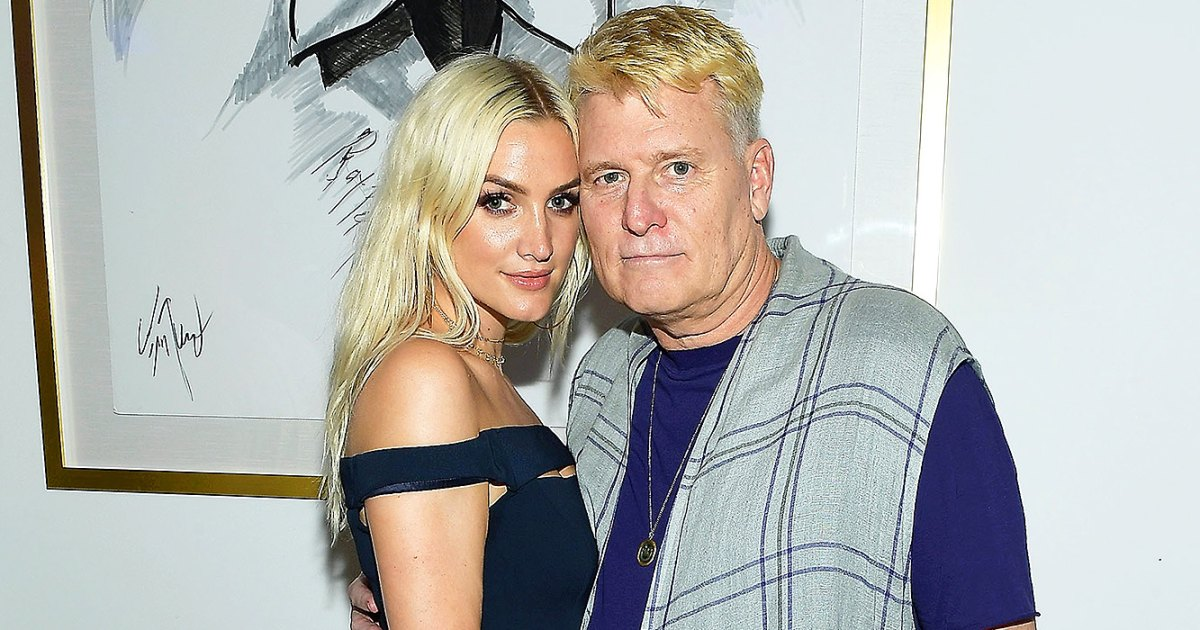

In [ ]:
from PIL import Image
import IPython.display as display

# 读取图片
image_path = "drive/MyDrive/fakenewsnet_dataset/top_images/gossipcop-809314.JPG"
image = Image.open(image_path)

# 展示图片
display.display(image)

In [ ]:
file_dirs[:5]

['gossipcop-1823945424.JPG',
 'gossipcop-8666163098.JPG',
 'gossipcop-8017572914.JPG',
 'gossipcop-2389938114.JPG',
 'gossipcop-7417601289.jpg']

In [ ]:
import pickle

# 假设你有 texts, labels, titles, file_dir 这些对象

# 指定保存文件的路径
save_path = 'drive/MyDrive/fakenewsnet_dataset/'

# 保存 texts 到文件
with open(save_path + 'texts.pkl', 'wb') as file:
    pickle.dump(texts, file)

# 保存 labels 到文件
with open(save_path + 'labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

# 保存 titles 到文件
with open(save_path + 'titles.pkl', 'wb') as file:
    pickle.dump(titles, file)

# 保存 file_dir 到文件
with open(save_path + 'filedirs.pkl', 'wb') as file:
    pickle.dump(file_dirs, file)


In [ ]:
import pickle


# 指定保存文件的路径
save_path = 'drive/MyDrive/fakenewsnet_dataset/'

with open(save_path + 'texts.pkl', 'rb') as file:
    texts=pickle.load(file)


with open(save_path + 'labels.pkl', 'rb') as file:
    labels=pickle.load(file)


with open(save_path + 'titles.pkl', 'rb') as file:
    titles=pickle.load(file)


with open(save_path + 'filedirs.pkl', 'rb') as file:
    file_dirs=pickle.load(file)

In [ ]:
len(texts),len(labels),len(titles),len(file_dirs)

(21067, 21067, 21067, 21067)

In [ ]:
texts[2]

'When pulled over, Woods was “extremely slow,” slurred his words and changed his story several times, according to the court records.\n\nWoods released a statement on Sunday night writing that alcohol was not involved. The court documents from Woods’ arrest state Woods told officers at the scene that he was on several medications.'

# **encoding**

In [ ]:
!pip uninstall transformers
!pip install --no-cache-dir transformers sentencepiece

Found existing installation: transformers 4.35.2
Uninstalling transformers-4.35.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.35.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 384.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

# From https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
#model_name_sentiment variable contains the name of the pre-trained model to be used
model_name_sentiment = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

#loads the tokenizer for the pre-trained model specified by model_name_sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name_sentiment,use_fast=False)
#config = AutoConfig.from_pretrained(model_name_sentiment)

# loads the pre-trained sentiment analysis model specified by model_name_sentiment
sentmodel = AutoModelForSequenceClassification.from_pretrained(model_name_sentiment)

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
bert = AutoModel.from_pretrained('bert-base-multilingual-cased')

# Initialize the PyTorch model
class BertEncoder(torch.nn.Module):
    def __init__(self, bert_model):
        super(BertEncoder, self).__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

# Create an instance of the PyTorch model
bertmodel = BertEncoder(bert)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bertmodel = bertmodel.to(device)
sentmodel = sentmodel.to(device)

def encode_text_with_bert(text_list, max_len=70, batch_size=32):

    # Tokenize and prepare input tensors
    X_batch = tokenizer(
        text=text_list,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    # Move inputs to GPU if available
    input_ids = X_batch['input_ids'].to(device)
    attention_mask = X_batch['attention_mask'].to(device)

    # Forward pass to obtain text encodings
    with torch.no_grad():
        text_encodings = bertmodel(input_ids, attention_mask)
        sent_encodings = F.softmax(sentmodel(input_ids, attention_mask = attention_mask).logits,dim=1)
    return text_encodings,sent_encodings

# # Example usage
# seltweet = ["Your", "list", "of", "sad"]
# encoded_result = encode_text_with_bert(seltweet, max_len=70, batch_size=32)
# encoded_result

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# Load the ResNet50 model
baseModel = models.resnet50(pretrained=True)
# Remove the fully connected layers at the end
baseModel = nn.Sequential(*list(baseModel.children())[:-2])

# Add a pooling layer
headModel = nn.AdaptiveAvgPool2d((1, 1))

# Create a new model
model_img = nn.Sequential(baseModel, headModel)

# Move the model to the GPU if available
model_img = model_img.to(device)

# Print the model architecture
# print(model_img)

# Note: PyTorch automatically enables GPU acceleration when available, so there's no need for explicit conversions like in TensorFlow.


Device:  cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.7MB/s]


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from torch.utils.data import Subset, random_split
from torch.nn.utils.rnn import pad_sequence

# 设置启动方法为 'spawn'，避免 CUDA 初始化问题
mp.set_start_method('spawn', force=True)

img_dir = 'drive/MyDrive/fakenewsnet_dataset/top_images'

def load_and_transform_data(item):
    file_dirs, texts, labels = item
    try:
      img_path = os.path.join(img_dir, file_dirs)
      image = Image.open(img_path)
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image = image.resize((224, 224))

      transform = transforms.ToTensor()

      image_tensor = transform(image).to(device)
    except Exception as e:
      white_image = Image.new('RGB', (224, 224), color='white')
      transform = transforms.ToTensor()
      image_tensor = transform(white_image).to(device)

    with torch.no_grad():
        img_enc = model_img(image_tensor.unsqueeze(0))

        text_enc, sent_enc = encode_text_with_bert(texts)

    return img_enc.squeeze([0, 2, 3]), text_enc.squeeze(0), sent_enc.squeeze(0), labels

class FeatureDataset(Dataset):
    def __init__(self, file_dirs, texts, labels):
        self.data = list(zip(file_dirs, texts, labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]

def collate_fn(batch):
    img_enc, text_enc, sent_enc, labels = zip(*batch)

    # Pad text_enc to the specified seq_len
    seq_len = 70
    text_enc_padded = pad_sequence(text_enc, batch_first=True, padding_value=0)

    # If the sequence length is less than seq_len, pad with zeros
    if text_enc_padded.size(1) < seq_len:
        padding_size = seq_len - text_enc_padded.size(1)
        text_enc_padded = F.pad(text_enc_padded, (0, padding_size), value=0)

    return (
        torch.stack(img_enc),
        text_enc_padded,
        torch.stack(sent_enc),
        torch.tensor(labels).long()
    )


dataset = FeatureDataset(file_dirs, texts, labels)
# dataset = dataset[:50]
def parallel_data_loading(item):
    return load_and_transform_data(item)

# 使用 ThreadPoolExecutor 并显示进度条
with ThreadPoolExecutor() as executor, tqdm(total=len(dataset), desc="Data Loading") as pbar:
    processed_data = list(tqdm(executor.map(parallel_data_loading, dataset), total=len(dataset)))
    pbar.update(len(dataset))






Data Loading: 100%|██████████| 21067/21067 [26:14<00:00, 13.38it/s]


In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * len(processed_data))
test_size = len(processed_data) - train_size

# 使用 random_split 进行划分
train_dataset, test_dataset = random_split(processed_data, [train_size, test_size])

# 创建对应的 DataLoader
batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=collate_fn
)

next(iter(train_loader))[1].shape

torch.Size([32, 70, 768])

In [ ]:
import math
import random
import numpy as np
from random import random, seed
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal, Independent #used to define probability distributions for the network's latent variables.
from torch.nn.functional import softplus #used to apply the softplus activation function to the network's outputs


#random.seed(825)
seed(825) #changes random initialization of model

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class FastCNN(nn.Module):
    ''' a CNN-based altertative approach of bert for text encoding,
    It takes in two parameters: channel and kernel_size.
    The channel parameter specifies the number of channels in the convolutional layers of the network,
     and the kernel_size parameter specifies the size of the kernel
     (i.e. the window of values that the convolutional layer operates over) for each of the
     convolutional layers in the network.'''
    def __init__(self, channel=32, kernel_size=(1, 2, 4, 8)):
        super(FastCNN, self).__init__()
        self.fast_cnn = nn.ModuleList()
        for kernel in kernel_size:
            self.fast_cnn.append(
                nn.Sequential(
                    nn.Conv1d(768, channel, kernel_size=kernel),
                    nn.BatchNorm1d(channel),
                    nn.ReLU(),
                    nn.AdaptiveMaxPool1d(1)
                )
            )
    ''' The forward method that takes in a tensor of text data,
     applies a series of convolutional, batch normalization, ReLU activation, and max pooling
     operations to the input, and returns the resulting encoded text.'''
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x_out = []
        for module in self.fast_cnn:
            x_out.append(module(x).squeeze())
        x_out = torch.cat(x_out, 1)
        return x_out


class EncodingPart(nn.Module):
    ''' The EncodingPart class also extends the nn.Module class and is used to encode both text and image data
  into a shared latent space. It takes in four parameters: cnn_channel, cnn_kernel_size, shared_image_dim,
  and shared_text_dim. These parameters are used to define the FastCNN instance that is used to encode
   the text data, as well as the dimensions of the shared latent space for the text and image data. '''

    def __init__(
        self,
        cnn_channel=32,
        cnn_kernel_size=(1, 2, 4, 8),
        shared_image_dim=128,
        shared_text_dim=128
    ):
        super(EncodingPart, self).__init__()
        self.shared_text_encoding = FastCNN(
            channel=cnn_channel,
            kernel_size=cnn_kernel_size
        )
        self.shared_text_linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, shared_text_dim),
            nn.BatchNorm1d(shared_text_dim),
            nn.ReLU()
        )
        self.shared_image = nn.Sequential(
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, shared_image_dim),
            nn.BatchNorm1d(shared_image_dim),
            nn.ReLU()
        )
        '''The forward method that takes in text and image data as input, applies the
   FastCNN model to the text data to encode it, applies two linear transformations to the encoded text data
    and the image data, and returns the resulting shared latent space representation for the text and image data.'''
    def forward(self, text, image):
        text_encoding = self.shared_text_encoding(text)
        if text_encoding is None:
          raise ValueError("text_encoding is None")
        text_shared = self.shared_text_linear(text_encoding)
        image_shared = self.shared_image(image)
        return text_shared, image_shared


class SimilarityModule(nn.Module): #crossModalAlignment
    '''This code defines a PyTorch nn.Module called SimilarityModule that represents a neural network for
  computing the similarity between a piece of text and an image. The network consists of three main parts:
  an encoding part, a text alignment part, and an image alignment part.The EncodingPart class is used to
  encode the text and image data into a shared latent space representation. The text_aligner and
   image_aligner modules are used to align the latent space representations of the text and image data,
   respectively. Finally, the sim_classifier module is used to classify the aligned latent space
  representations of the text and image data into two classes based on their similarity.This class takes
  a piece of text and an image as input, and returns the aligned latent space representations of the text
   and image data, as well as the predicted similarity between the text and image.'''
    def __init__(self, shared_dim=128, sim_dim=64):
        super(SimilarityModule, self).__init__()
        self.encoding = EncodingPart()
        self.text_aligner = nn.Sequential(
            nn.Linear(shared_dim, shared_dim),
            nn.BatchNorm1d(shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, sim_dim),
            nn.BatchNorm1d(sim_dim),
            nn.ReLU()
        )
        self.image_aligner = nn.Sequential(
            nn.Linear(shared_dim, shared_dim),
            nn.BatchNorm1d(shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, sim_dim),
            nn.BatchNorm1d(sim_dim),
            nn.ReLU()
        )
        self.sim_classifier_dim = sim_dim * 2
        self.sim_classifier = nn.Sequential(
            nn.BatchNorm1d(self.sim_classifier_dim),
            nn.Linear(self.sim_classifier_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.fc_comm_extract = nn.Linear(256, 768)

    def forward(self, text, image):
        text_encoding, image_encoding = self.encoding(text, image)
        common_feature = torch.cat([text_encoding, image_encoding], -1)
        common_feature = self.fc_comm_extract(common_feature)
        text_aligned = self.text_aligner(text_encoding) #text_aligned=mt in paper
        image_aligned = self.image_aligner(image_encoding) #image_aligned=mv in paper
        sim_feature = torch.cat([text_aligned, image_aligned], 1)
        pred_similarity = self.sim_classifier(sim_feature) #pred_similarity=predicted similarity label between the text and image
        return text_aligned, image_aligned, pred_similarity, common_feature #pred_similarity=1:text-img pair is from same real news,pred_similarity=0:text-img pair is from different real news



class Encoder(nn.Module):
    ''' The Encoder class represents a neural network that takes as input an encoded text or image
      representation and outputs a distribution over the latent space of the text or image data.'''

    def __init__(self, z_dim=2):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Linear(64, z_dim * 2),
        )

    def forward(self, x):
        # x = x.view(x.size(0), -1)  # Flatten the input
        params = self.net(x)
        mu, sigma = params[:, :self.z_dim], params[:, self.z_dim:]
        sigma = softplus(sigma) + 1e-7
        return Independent(Normal(loc=mu, scale=sigma), 1)


class AmbiguityLearning(nn.Module): #AmbiguityLearningModule
    '''is a more complex neural network that uses the Encoder class to learn the ambiguity of text and image
   data by computing the symmetric Kullback-Leibler (SKL) divergence between the distributions of the latent
  space representations of the text and image data.'''
    def __init__(self):
        super(AmbiguityLearning, self).__init__()
        self.encoding = EncodingPart()
        self.encoder_text = Encoder()
        self.encoder_image = Encoder()

    def forward(self, text_encoding, image_encoding):
        '''takes as input the encoded text and image representations, and uses the Encoder class to compute
      the distributions over the latent space of the text and image data. The SKL divergence (measure of the difference between two probability distributions) between the two
       distributions is then computed and returned. The SKL divergence is a measure of the difference between
       the two distributions, and can be used as a proxy for the ambiguity of the text and image data.'''
        # text_encoding, image_encoding = self.encoding(text, image)
        p_z1_given_text = self.encoder_text(text_encoding) #here computes distribution of text data in latent space using Encoder class
        p_z2_given_image = self.encoder_image(image_encoding) #here computes distribution of img data in latent space using Encoder class
        z1 = p_z1_given_text.rsample() #.rsample= isotropic Gaussian priors that the unimodal features (mt-text or mv-img) are sampled froma latent space Rd
        z2 = p_z2_given_image.rsample()
        kl_1_2 = p_z1_given_text.log_prob(z1) - p_z2_given_image.log_prob(z1) #divergence between text n img at point z1 sampled from from the distribution p_z1_given_text
        kl_2_1 = p_z2_given_image.log_prob(z2) - p_z1_given_text.log_prob(z2)
        skl = (kl_1_2 + kl_2_1)/ 2. #computes the SKL divergence between the two distributions and applies the sigmoid function to the result.
        skl = torch.sigmoid(skl)
        return skl #SKL divergence between the two distributions


class UnimodalDetection(nn.Module):
        '''a neural network for detecting whether a piece of text or image data is unimodal
  (i.e., only contains information from one modality, either text or image).'''
        def __init__(self, shared_dim=128, prime_dim = 16):
            super(UnimodalDetection, self).__init__()
            self.text_uni = nn.Sequential(
                nn.Linear(shared_dim, shared_dim),
                nn.BatchNorm1d(shared_dim),
                nn.ReLU(),
                nn.Linear(shared_dim, prime_dim),
                nn.BatchNorm1d(prime_dim),
                nn.ReLU()
            )
            self.image_uni = nn.Sequential(
                nn.Linear(shared_dim, shared_dim),
                nn.BatchNorm1d(shared_dim),
                nn.ReLU(),
                nn.Linear(shared_dim, prime_dim),
                nn.BatchNorm1d(prime_dim),
                nn.ReLU()
            )

        def forward(self, text_encoding, image_encoding): #takes input encoded text & img
            '''takes as input the encoded text and image representations, and uses the text_uni and image_uni
          modules to detect whether the text and image data, respectively, are unimodal. The method returns
          the output of the two
          unimodal detection modules, which can be used to classify the text and image data as unimodal or not.'''
            text_prime = self.text_uni(text_encoding)
            image_prime = self.image_uni(image_encoding)
            return text_prime, image_prime


class CrossModule4Batch(nn.Module): #CrossModalFusion
    '''represents a neural network for computing the cross-modal correlation between text and image data.
    '''
    def __init__(self, text_in_dim=64, image_in_dim=64, corre_out_dim=64):
        super(CrossModule4Batch, self).__init__()
        self.softmax = nn.Softmax(-1)
        self.corre_dim = 64
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.c_specific_2 = nn.Sequential(
            nn.Linear(self.corre_dim, corre_out_dim),
            nn.BatchNorm1d(corre_out_dim),
            nn.ReLU()
        )

    def forward(self, text, image):
        '''takes as input the text and image representations, and uses these inputs to compute a similarity matrix.
      This matrix is then passed through a softmax function and a max pooling layer to compute a correlation
      score for each text-image pair. The method returns the output of the correlation module, which can be
      used to measure the degree of correlation between the text and image data.'''

        text_in = text.unsqueeze(2)
        image_in = image.unsqueeze(1)
        corre_dim = text.shape[1]
        similarity = torch.matmul(text_in, image_in) / math.sqrt(corre_dim)
        correlation = self.softmax(similarity)
        correlation_p = self.pooling(correlation).squeeze()
        correlation_out = self.c_specific_2(correlation_p)
        return correlation_out


class DetectionModule(nn.Module):
    '''takes as input raw text and image data, as well as encoded versions of the text and image data,
  and outputs a predicted label. The module consists of several submodules: an EncodingPart module that
   encodes the raw text and image data, an AmbiguityLearning module that computes the ambiguity between
   the encoded text and image, a UnimodalDetection module that generates unimodal representations of the
   encoded text and image data, a CrossModule4Batch module that computes the correlation between the unimodal
   representations,   and a classifier that combines these intermediate outputs and predicts the final label.

   If sentiment is True, then the sentiment analysis output is weighted using the same weight as the unimodal
    representations and concatenated to the final input before passing through the classifier_corre module.'''

    def __init__(self, feature_dim=64+16+16, h_dim=64, sentiment=False):
        super(DetectionModule, self).__init__()
        self.sentiment = sentiment
        self.encoding = EncodingPart()
        self.ambiguity_module = AmbiguityLearning()
        self.uni_repre = UnimodalDetection()
        self.cross_module = CrossModule4Batch()
        if self.sentiment:
          feature_dim += 3
        self.classifier_corre = nn.Sequential(
            nn.Linear(feature_dim, h_dim),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(h_dim, h_dim),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(h_dim, 2)
        )

    def forward(self, text_raw, image_raw, text, image, sent=None):
        # text_encoding, image_encoding = self.encoding_module(text, image)
        skl = self.ambiguity_module(text, image)
        text_prime, image_prime = self.encoding(text_raw, image_raw)
        text_prime, image_prime = self.uni_repre(text_prime, image_prime)
        correlation = self.cross_module(text, image)
        weight_uni = (1-skl).unsqueeze(1)
        weight_corre = skl.unsqueeze(1)
        text_final = weight_uni * text_prime
        img_final = weight_uni * image_prime
        corre_final = weight_corre * correlation
        final_corre = torch.cat([text_final, img_final, corre_final], 1) #applies these modules to the input text and image data to compute a correlation score, which is then passed through a linear classifier to produce a prediction of whether the text and image data are correlated or not.
        if self.sentiment:
          sent = sent * weight_uni # Comment weight if no 1-alpha
          final_corre = torch.cat([final_corre, sent], 1)
        pre_label = self.classifier_corre(final_corre)
        return pre_label
'''
'''

'\n'

264it [00:14, 17.76it/s]


---  TASK1 Similarity  ---
EPOCH = 1 
 acc_similarity_train = 0.251 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.243 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 1 
 acc_detection_train = 0.769 
 acc_detection_test = 0.747 
  best_acc = 0.747 
 loss_detection_train = 0.661 
 loss_detection_test = 0.622 

---  TASK1 Similarity Confusion Matrix  ---
[[   4    7]
 [3126 3123]]

---  TASK2 Detection Confusion Matrix  ---
[[  16    0]
 [1068 3130]]



264it [00:15, 16.53it/s]


---  TASK1 Similarity  ---
EPOCH = 2 
 acc_similarity_train = 0.249 
 acc_similarity_test = 0.495 
 loss_similarity_train = 0.244 
 loss_similarity_test = 0.503 

---  TASK2 Detection  ---
EPOCH = 2 
 acc_detection_train = 0.781 
 acc_detection_test = 0.773 
  best_acc = 0.773 
 loss_detection_train = 0.514 
 loss_detection_test = 0.515 

---  TASK1 Similarity Confusion Matrix  ---
[[1127 1159]
 [2003 1971]]

---  TASK2 Detection Confusion Matrix  ---
[[ 153   26]
 [ 931 3104]]



264it [00:12, 20.89it/s]


---  TASK1 Similarity  ---
EPOCH = 3 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 3 
 acc_detection_train = 0.788 
 acc_detection_test = 0.752 
  best_acc = 0.773 
 loss_detection_train = 0.500 
 loss_detection_test = 0.543 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[  38    0]
 [1046 3130]]



264it [00:12, 21.49it/s]


---  TASK1 Similarity  ---
EPOCH = 4 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 4 
 acc_detection_train = 0.783 
 acc_detection_test = 0.778 
  best_acc = 0.778 
 loss_detection_train = 0.497 
 loss_detection_test = 0.512 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[ 179   29]
 [ 905 3101]]



264it [00:11, 22.80it/s]


---  TASK1 Similarity  ---
EPOCH = 5 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 5 
 acc_detection_train = 0.786 
 acc_detection_test = 0.748 
  best_acc = 0.778 
 loss_detection_train = 0.495 
 loss_detection_test = 0.556 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[  25    1]
 [1059 3129]]



264it [00:11, 22.15it/s]


---  TASK1 Similarity  ---
EPOCH = 6 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 6 
 acc_detection_train = 0.787 
 acc_detection_test = 0.792 
  best_acc = 0.792 
 loss_detection_train = 0.494 
 loss_detection_test = 0.498 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[ 289   82]
 [ 795 3048]]



264it [00:12, 20.81it/s]


---  TASK1 Similarity  ---
EPOCH = 7 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 7 
 acc_detection_train = 0.787 
 acc_detection_test = 0.797 
  best_acc = 0.797 
 loss_detection_train = 0.495 
 loss_detection_test = 0.487 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[ 308   79]
 [ 776 3051]]



264it [00:12, 20.91it/s]


---  TASK1 Similarity  ---
EPOCH = 8 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 8 
 acc_detection_train = 0.785 
 acc_detection_test = 0.788 
  best_acc = 0.797 
 loss_detection_train = 0.496 
 loss_detection_test = 0.491 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[ 395  204]
 [ 689 2926]]



264it [00:12, 20.54it/s]


---  TASK1 Similarity  ---
EPOCH = 9 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 9 
 acc_detection_train = 0.790 
 acc_detection_test = 0.793 
  best_acc = 0.797 
 loss_detection_train = 0.492 
 loss_detection_test = 0.497 

---  TASK1 Similarity Confusion Matrix  ---
[[3130 3130]
 [   0    0]]

---  TASK2 Detection Confusion Matrix  ---
[[ 277   65]
 [ 807 3065]]



264it [00:12, 21.07it/s]


---  TASK1 Similarity  ---
EPOCH = 10 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 10 
 acc_detection_train = 0.788 
 acc_detection_test = 0.744 
  best_acc = 0.797 
 loss_detection_train = 0.490 
 loss_detection_test = 0.539 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 661  657]
 [ 423 2473]]



264it [00:12, 20.84it/s]


---  TASK1 Similarity  ---
EPOCH = 11 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 11 
 acc_detection_train = 0.787 
 acc_detection_test = 0.787 
  best_acc = 0.797 
 loss_detection_train = 0.496 
 loss_detection_test = 0.493 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 340  152]
 [ 744 2978]]



264it [00:12, 21.68it/s]


---  TASK1 Similarity  ---
EPOCH = 12 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 12 
 acc_detection_train = 0.783 
 acc_detection_test = 0.774 
  best_acc = 0.797 
 loss_detection_train = 0.495 
 loss_detection_test = 0.520 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 158   27]
 [ 926 3103]]



264it [00:12, 21.94it/s]


---  TASK1 Similarity  ---
EPOCH = 13 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 13 
 acc_detection_train = 0.790 
 acc_detection_test = 0.787 
  best_acc = 0.797 
 loss_detection_train = 0.491 
 loss_detection_test = 0.498 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 318  133]
 [ 766 2997]]



264it [00:11, 22.47it/s]


---  TASK1 Similarity  ---
EPOCH = 14 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 14 
 acc_detection_train = 0.788 
 acc_detection_test = 0.725 
  best_acc = 0.797 
 loss_detection_train = 0.494 
 loss_detection_test = 0.606 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 651  727]
 [ 433 2403]]



264it [00:11, 23.11it/s]


---  TASK1 Similarity  ---
EPOCH = 15 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 15 
 acc_detection_train = 0.790 
 acc_detection_test = 0.778 
  best_acc = 0.797 
 loss_detection_train = 0.492 
 loss_detection_test = 0.508 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 194   47]
 [ 890 3083]]



264it [00:11, 22.40it/s]


---  TASK1 Similarity  ---
EPOCH = 16 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 16 
 acc_detection_train = 0.792 
 acc_detection_test = 0.757 
  best_acc = 0.797 
 loss_detection_train = 0.489 
 loss_detection_test = 0.544 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 575  515]
 [ 509 2615]]



264it [00:12, 21.52it/s]


---  TASK1 Similarity  ---
EPOCH = 17 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 17 
 acc_detection_train = 0.792 
 acc_detection_test = 0.797 
  best_acc = 0.797 
 loss_detection_train = 0.487 
 loss_detection_test = 0.480 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 278   51]
 [ 806 3079]]



264it [00:14, 18.50it/s]


---  TASK1 Similarity  ---
EPOCH = 18 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 18 
 acc_detection_train = 0.789 
 acc_detection_test = 0.788 
  best_acc = 0.797 
 loss_detection_train = 0.494 
 loss_detection_test = 0.504 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 399  210]
 [ 685 2920]]



264it [00:12, 20.88it/s]


---  TASK1 Similarity  ---
EPOCH = 19 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 19 
 acc_detection_train = 0.787 
 acc_detection_test = 0.777 
  best_acc = 0.797 
 loss_detection_train = 0.497 
 loss_detection_test = 0.496 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 430  285]
 [ 654 2845]]



264it [00:12, 20.75it/s]


---  TASK1 Similarity  ---
EPOCH = 20 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 20 
 acc_detection_train = 0.788 
 acc_detection_test = 0.800 
  best_acc = 0.800 
 loss_detection_train = 0.493 
 loss_detection_test = 0.489 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 319   78]
 [ 765 3052]]



264it [00:12, 20.93it/s]


---  TASK1 Similarity  ---
EPOCH = 21 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 21 
 acc_detection_train = 0.791 
 acc_detection_test = 0.764 
  best_acc = 0.800 
 loss_detection_train = 0.492 
 loss_detection_test = 0.549 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[  99    8]
 [ 985 3122]]



264it [00:12, 20.79it/s]


---  TASK1 Similarity  ---
EPOCH = 22 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 22 
 acc_detection_train = 0.787 
 acc_detection_test = 0.782 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.509 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 422  255]
 [ 662 2875]]



264it [00:12, 21.43it/s]


---  TASK1 Similarity  ---
EPOCH = 23 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 23 
 acc_detection_train = 0.795 
 acc_detection_test = 0.800 
  best_acc = 0.800 
 loss_detection_train = 0.488 
 loss_detection_test = 0.485 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 332   92]
 [ 752 3038]]



264it [00:12, 21.24it/s]


---  TASK1 Similarity  ---
EPOCH = 24 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 24 
 acc_detection_train = 0.787 
 acc_detection_test = 0.786 
  best_acc = 0.800 
 loss_detection_train = 0.489 
 loss_detection_test = 0.527 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 508  324]
 [ 576 2806]]



264it [00:12, 21.44it/s]


---  TASK1 Similarity  ---
EPOCH = 25 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 25 
 acc_detection_train = 0.785 
 acc_detection_test = 0.797 
  best_acc = 0.800 
 loss_detection_train = 0.493 
 loss_detection_test = 0.490 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 339  109]
 [ 745 3021]]



264it [00:12, 21.16it/s]


---  TASK1 Similarity  ---
EPOCH = 26 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 26 
 acc_detection_train = 0.790 
 acc_detection_test = 0.796 
  best_acc = 0.800 
 loss_detection_train = 0.487 
 loss_detection_test = 0.486 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 406  182]
 [ 678 2948]]



264it [00:12, 21.33it/s]


---  TASK1 Similarity  ---
EPOCH = 27 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 27 
 acc_detection_train = 0.794 
 acc_detection_test = 0.761 
  best_acc = 0.800 
 loss_detection_train = 0.487 
 loss_detection_test = 0.525 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[  84    9]
 [1000 3121]]



264it [00:11, 22.25it/s]


---  TASK1 Similarity  ---
EPOCH = 28 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 28 
 acc_detection_train = 0.781 
 acc_detection_test = 0.750 
  best_acc = 0.800 
 loss_detection_train = 0.507 
 loss_detection_test = 0.521 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 637  605]
 [ 447 2525]]



264it [00:11, 23.85it/s]


---  TASK1 Similarity  ---
EPOCH = 29 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 29 
 acc_detection_train = 0.776 
 acc_detection_test = 0.778 
  best_acc = 0.800 
 loss_detection_train = 0.511 
 loss_detection_test = 0.516 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 234   86]
 [ 850 3044]]



264it [00:11, 22.93it/s]


---  TASK1 Similarity  ---
EPOCH = 30 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 30 
 acc_detection_train = 0.786 
 acc_detection_test = 0.782 
  best_acc = 0.800 
 loss_detection_train = 0.494 
 loss_detection_test = 0.498 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 234   69]
 [ 850 3061]]



264it [00:12, 21.82it/s]


---  TASK1 Similarity  ---
EPOCH = 31 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 31 
 acc_detection_train = 0.787 
 acc_detection_test = 0.753 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.576 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[  49    7]
 [1035 3123]]



264it [00:12, 21.08it/s]


---  TASK1 Similarity  ---
EPOCH = 32 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 32 
 acc_detection_train = 0.788 
 acc_detection_test = 0.780 
  best_acc = 0.800 
 loss_detection_train = 0.492 
 loss_detection_test = 0.512 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 191   36]
 [ 893 3094]]



264it [00:12, 21.43it/s]


---  TASK1 Similarity  ---
EPOCH = 33 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 33 
 acc_detection_train = 0.786 
 acc_detection_test = 0.772 
  best_acc = 0.800 
 loss_detection_train = 0.498 
 loss_detection_test = 0.539 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 141   17]
 [ 943 3113]]



264it [00:12, 21.63it/s]


---  TASK1 Similarity  ---
EPOCH = 34 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 34 
 acc_detection_train = 0.786 
 acc_detection_test = 0.784 
  best_acc = 0.800 
 loss_detection_train = 0.492 
 loss_detection_test = 0.492 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 236   62]
 [ 848 3068]]



264it [00:12, 21.20it/s]


---  TASK1 Similarity  ---
EPOCH = 35 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 35 
 acc_detection_train = 0.792 
 acc_detection_test = 0.785 
  best_acc = 0.800 
 loss_detection_train = 0.487 
 loss_detection_test = 0.505 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 219   41]
 [ 865 3089]]



264it [00:12, 21.32it/s]


---  TASK1 Similarity  ---
EPOCH = 36 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 36 
 acc_detection_train = 0.791 
 acc_detection_test = 0.781 
  best_acc = 0.800 
 loss_detection_train = 0.493 
 loss_detection_test = 0.507 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 489  327]
 [ 595 2803]]



264it [00:12, 21.42it/s]


---  TASK1 Similarity  ---
EPOCH = 37 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 37 
 acc_detection_train = 0.791 
 acc_detection_test = 0.747 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.584 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[  18    0]
 [1066 3130]]



264it [00:12, 21.38it/s]


---  TASK1 Similarity  ---
EPOCH = 38 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 38 
 acc_detection_train = 0.790 
 acc_detection_test = 0.789 
  best_acc = 0.800 
 loss_detection_train = 0.492 
 loss_detection_test = 0.538 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 288   92]
 [ 796 3038]]



264it [00:12, 21.33it/s]


---  TASK1 Similarity  ---
EPOCH = 39 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 39 
 acc_detection_train = 0.789 
 acc_detection_test = 0.800 
  best_acc = 0.800 
 loss_detection_train = 0.489 
 loss_detection_test = 0.486 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 338   98]
 [ 746 3032]]



264it [00:12, 21.38it/s]


---  TASK1 Similarity  ---
EPOCH = 40 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 40 
 acc_detection_train = 0.787 
 acc_detection_test = 0.758 
  best_acc = 0.800 
 loss_detection_train = 0.489 
 loss_detection_test = 0.585 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 596  532]
 [ 488 2598]]



264it [00:11, 22.15it/s]


---  TASK1 Similarity  ---
EPOCH = 41 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 41 
 acc_detection_train = 0.788 
 acc_detection_test = 0.583 
  best_acc = 0.800 
 loss_detection_train = 0.488 
 loss_detection_test = 0.690 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 788 1460]
 [ 296 1670]]



264it [00:11, 22.27it/s]


---  TASK1 Similarity  ---
EPOCH = 42 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 42 
 acc_detection_train = 0.787 
 acc_detection_test = 0.789 
  best_acc = 0.800 
 loss_detection_train = 0.495 
 loss_detection_test = 0.499 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 235   40]
 [ 849 3090]]



264it [00:12, 21.52it/s]


---  TASK1 Similarity  ---
EPOCH = 43 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 43 
 acc_detection_train = 0.785 
 acc_detection_test = 0.764 
  best_acc = 0.800 
 loss_detection_train = 0.496 
 loss_detection_test = 0.535 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 436  346]
 [ 648 2784]]



264it [00:12, 21.42it/s]


---  TASK1 Similarity  ---
EPOCH = 44 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 44 
 acc_detection_train = 0.791 
 acc_detection_test = 0.789 
  best_acc = 0.800 
 loss_detection_train = 0.489 
 loss_detection_test = 0.492 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 290   97]
 [ 794 3033]]



264it [00:12, 20.97it/s]


---  TASK1 Similarity  ---
EPOCH = 45 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 45 
 acc_detection_train = 0.786 
 acc_detection_test = 0.791 
  best_acc = 0.800 
 loss_detection_train = 0.490 
 loss_detection_test = 0.493 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 286   81]
 [ 798 3049]]



264it [00:12, 21.37it/s]


---  TASK1 Similarity  ---
EPOCH = 46 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 46 
 acc_detection_train = 0.786 
 acc_detection_test = 0.783 
  best_acc = 0.800 
 loss_detection_train = 0.492 
 loss_detection_test = 0.506 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 234   64]
 [ 850 3066]]



264it [00:12, 21.19it/s]


---  TASK1 Similarity  ---
EPOCH = 47 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 47 
 acc_detection_train = 0.789 
 acc_detection_test = 0.796 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.493 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 334  111]
 [ 750 3019]]



264it [00:12, 21.02it/s]


---  TASK1 Similarity  ---
EPOCH = 48 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 48 
 acc_detection_train = 0.788 
 acc_detection_test = 0.763 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.524 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 545  458]
 [ 539 2672]]



264it [00:12, 21.37it/s]


---  TASK1 Similarity  ---
EPOCH = 49 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 49 
 acc_detection_train = 0.793 
 acc_detection_test = 0.783 
  best_acc = 0.800 
 loss_detection_train = 0.488 
 loss_detection_test = 0.570 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 220   52]
 [ 864 3078]]



264it [00:12, 20.97it/s]


---  TASK1 Similarity  ---
EPOCH = 50 
 acc_similarity_train = 0.250 
 acc_similarity_test = 0.500 
 loss_similarity_train = 0.250 
 loss_similarity_test = 0.500 

---  TASK2 Detection  ---
EPOCH = 50 
 acc_detection_train = 0.787 
 acc_detection_test = 0.785 
  best_acc = 0.800 
 loss_detection_train = 0.491 
 loss_detection_test = 0.502 

---  TASK1 Similarity Confusion Matrix  ---
[[   0    0]
 [3130 3130]]

---  TASK2 Detection Confusion Matrix  ---
[[ 267   90]
 [ 817 3040]]



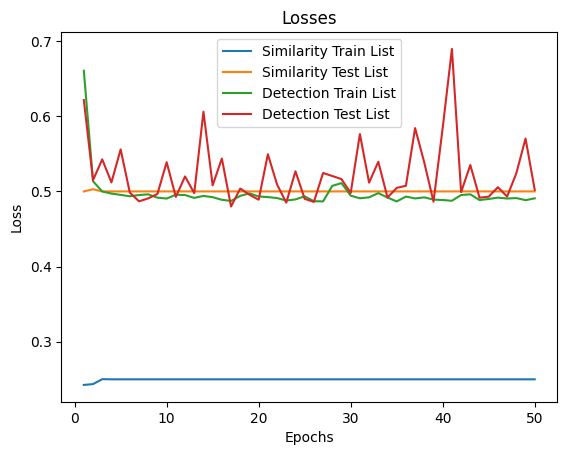

In [ ]:
import copy
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm



# Configs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SENTIMENT = True

NUM_WORKER = 1
BATCH_SIZE = 64
LR = 0.01
L2 = 0.01 # 1e-5
TRAIN_RATIO = 0.8
NUM_EPOCH = 50



def prepare_data(text, image, sentiment, label):
    nr_index = [i for i, l in enumerate(label) if l == 1]

    text_nr = text[nr_index]
    sentiment_nr = sentiment[nr_index]
    image_nr = image[nr_index]
    fixed_text = copy.deepcopy(text_nr)
    fixed_sent = copy.deepcopy(sentiment_nr)
    matched_image = copy.deepcopy(image_nr)
    unmatched_image = copy.deepcopy(image_nr).roll(shifts=3, dims=0)
    return fixed_text, fixed_sent, matched_image, unmatched_image

def _calculate_orthogonal_regularization_F(view_feature, comm_feature):
     # Transpose 'comm_feature' if it is a 1D tensor to ensure proper matrix multiplication
    comm_feature_T = comm_feature.t()

    # If 'view_feature' is 1D, convert it to a 2D tensor with a single row
    if view_feature.dim() == 1:
        view_feature = view_feature.unsqueeze(0)

    # If 'comm_feature_T' is 1D, convert it to a 2D tensor with a single row
    if comm_feature_T.dim() == 1:
        comm_feature_T = comm_feature_T.unsqueeze(0)

    # Compute the loss as the squared Frobenius inner product between the two feature tensors
    loss = torch.matmul(view_feature, comm_feature_T)
    loss = loss ** 2

    # Sum all the elements in the loss tensor
    loss = loss.sum()

    # Normalize the loss by dividing it by the product of the sizes of both feature tensors
    loss /= (comm_feature.shape[0] * comm_feature.shape[0]
             * view_feature.shape[0] * view_feature.shape[0])

    return loss


def _calculate_orthogonal_regularization_L2(view_feature, comm_feature):

    comm_feature = comm_feature.t()
    # print(view_feature.shape, comm_feature.shape)
    # loss = torch.matmul(view_feature, comm_feature)
    loss = view_feature @ comm_feature
    loss = loss.sum(1)
    loss = loss ** 2
    loss = loss.sum()
    loss /= (comm_feature.shape[0] * comm_feature.shape[0]
             * view_feature.shape[0] * view_feature.shape[0])
    return loss

def _calculate_orthogonal_regularization_L1(view_feature, comm_feature):

    comm_feature = comm_feature.t()
    loss = view_feature @ comm_feature
    loss = loss.sum(1)
    loss = torch.abs(loss)
    loss = loss.sum()
    loss /= (comm_feature.shape[0] * comm_feature.shape[0]
             * view_feature.shape[0] * view_feature.shape[0])
    return loss



def train():
    # ---  Load Config  ---
    device = torch.device(DEVICE)
    num_workers = NUM_WORKER
    batch_size = BATCH_SIZE
    lr = LR
    l2 = L2
    train_ratio=TRAIN_RATIO
    num_epoch = NUM_EPOCH

    # ---  Load Data  ---

    train_size = int(train_ratio * len(processed_data))
    test_size = len(processed_data) - train_size

    # 使用 random_split 进行划分
    train_dataset, test_dataset = random_split(processed_data, [train_size, test_size])

    # 创建对应的 DataLoader

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, num_workers=0, shuffle=False, collate_fn=collate_fn
    )


    # ---  Build Model & Trainer  ---
    similarity_module = SimilarityModule()
    similarity_module.to(device)
    detection_module = DetectionModule(sentiment=SENTIMENT)
    detection_module.to(device)
    loss_func_similarity = torch.nn.CosineEmbeddingLoss()
    loss_func_detection = torch.nn.CrossEntropyLoss()
    optim_task_similarity = torch.optim.Adam(
        similarity_module.parameters(), lr=lr, weight_decay=l2
    )  # also called task1
    optim_task_detection = torch.optim.Adam(
        detection_module.parameters(), lr=lr, weight_decay=l2
    )  # also called task2

    # ---  Model Training  ---
    loss_similarity_total = 0
    loss_detection_total = 0
    best_acc = 0
    early_stopper = EarlyStopper(patience=5, min_delta= 0.100)
    loss_similarity_train_list = []
    loss_similarity_test_list  = []
    loss_detection_train_list = []
    loss_detection_test_list = []


    fc_comm_extract = nn.Linear(128, 768).to(device)  # Move to the same device as other tensors
    fc_image_extract = nn.Linear(2048, 768).to(device)




    for epoch in range(num_epoch):

        similarity_module.train()
        detection_module.train()
        corrects_pre_similarity = 0
        corrects_pre_detection = 0
        loss_similarity_total = 0
        loss_detection_total = 0
        similarity_count = 0
        detection_count = 0

        for i, (image, text, sentiment, label) in tqdm(enumerate(train_loader)):

            batch_size = text.shape[0]
            text = text.to(device)
            image = image.to(device)
            sentiment = sentiment.to(device)
            label = label.to(device)

            fixed_text, fixed_sent, matched_image, unmatched_image = prepare_data(text, image, sentiment, label)
            fixed_text.to(device)
            fixed_sent.to(device)
            matched_image.to(device)
            unmatched_image.to(device)


            # ---  TASK1 Similarity  ---



            text_aligned_match, image_aligned_match, pred_similarity_match, _  = similarity_module(fixed_text, matched_image)
            text_aligned_unmatch, image_aligned_unmatch, pred_similarity_unmatch, _  = similarity_module(fixed_text, unmatched_image)
            similarity_pred = torch.cat([pred_similarity_match.argmax(1), pred_similarity_unmatch.argmax(1)], dim=0)
            similarity_label_0 = torch.cat([torch.ones(pred_similarity_match.shape[0]), torch.zeros(pred_similarity_unmatch.shape[0])], dim=0).to(device)
            similarity_label_1 = torch.cat([torch.ones(pred_similarity_match.shape[0]), -1 * torch.ones(pred_similarity_unmatch.shape[0])], dim=0).to(device)

            text_aligned_4_task1 = torch.cat([text_aligned_match, text_aligned_unmatch], dim=0)
            image_aligned_4_task1 = torch.cat([image_aligned_match, image_aligned_unmatch], dim=0)
            loss_similarity = loss_func_similarity(text_aligned_4_task1, image_aligned_4_task1, similarity_label_1)

            optim_task_similarity.zero_grad()
            loss_similarity.backward()
            optim_task_similarity.step()

            corrects_pre_similarity += similarity_pred.eq(similarity_label_0).sum().item()

            # ---  TASK_2 Detection  ---

            text_aligned, image_aligned, _, comm_feature = similarity_module(text, image)

           #passed through a fully connected layer to reduce dimensionality
            matched_image = fc_image_extract(matched_image)

            #unsqueezed along the first dimension, adding a new dimension with size 1. This is done to match the dimensions for concatenation with fixed_text
            matched_image = matched_image.unsqueeze(1)

            #which is a tensor containing both the image and text concatenated
            view_feature = torch.cat((matched_image, fixed_text), dim=1)


            pre_detection = detection_module(text, image, text_aligned, image_aligned, sent=sentiment)
          #  loss_detection = loss_func_detection(pre_detection, label)
  #add Orthogonal regularization to Final loss of CAFE
            loss_detection = loss_func_detection(pre_detection, label) + _calculate_orthogonal_regularization_F(view_feature, comm_feature)

            optim_task_detection.zero_grad()
            loss_detection.backward()
            optim_task_detection.step()

            pre_label_detection = pre_detection.argmax(1)

            corrects_pre_detection += pre_label_detection.eq(label.view_as(pre_label_detection)).sum().item()

            # ---  Record  ---

            loss_similarity_total += loss_similarity.item() * (2 * fixed_text.shape[0])
            loss_detection_total += loss_detection.item() * text.shape[0]
            similarity_count += (2 * fixed_text.shape[0] * 2)
            detection_count += text.shape[0]

        loss_similarity_train = loss_similarity_total / similarity_count
        loss_detection_train = loss_detection_total / detection_count
        acc_similarity_train = corrects_pre_similarity / similarity_count
        acc_detection_train = corrects_pre_detection / detection_count

        # ---  Test  ---

        acc_similarity_test, acc_detection_test, loss_similarity_test, loss_detection_test, cm_similarity, cm_detection = test(similarity_module, detection_module, test_loader)
        best_acc=max(best_acc,acc_detection_test)
        # ---  Output  ---

        print('---  TASK1 Similarity  ---')
        print(
            "EPOCH = %d \n acc_similarity_train = %.3f \n acc_similarity_test = %.3f \n loss_similarity_train = %.3f \n loss_similarity_test = %.3f \n" %
            (epoch + 1, acc_similarity_train, acc_similarity_test, loss_similarity_train, loss_similarity_test)
        )

        print('---  TASK2 Detection  ---')
        print(
            "EPOCH = %d \n acc_detection_train = %.3f \n acc_detection_test = %.3f \n  best_acc = %.3f \n loss_detection_train = %.3f \n loss_detection_test = %.3f \n" %
            (epoch + 1, acc_detection_train, acc_detection_test, best_acc, loss_detection_train, loss_detection_test)
        )

        print('---  TASK1 Similarity Confusion Matrix  ---')
        print('{}\n'.format(cm_similarity))

        print('---  TASK2 Detection Confusion Matrix  ---')
        print('{}\n'.format(cm_detection))
        loss_similarity_train_list.append(loss_similarity_train)
        loss_similarity_test_list.append(loss_similarity_test)
        loss_detection_train_list.append(loss_detection_train)
        loss_detection_test_list.append(loss_detection_test)
        if early_stopper.early_stop(loss_detection_test):
          break

    epochs = range(1, epoch +2)
    # Plot and label the training and validation loss values
    plt.plot(epochs, loss_similarity_train_list, label='Similarity Train List')
    plt.plot(epochs, loss_similarity_test_list, label='Similarity Test List')

    plt.plot(epochs, loss_detection_train_list, label='Detection Train List')
    plt.plot(epochs, loss_detection_test_list, label='Detection Test List')

    # Add in a title and axes labels
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # Set the tick locations
    # plt.xticks(arange(0, 21, 2))
    # Display the plot
    plt.legend(loc='best')
    plt.show()


def test(similarity_module, detection_module, test_loader):
    similarity_module.eval()
    detection_module.eval()

    device = torch.device(DEVICE)
    loss_func_detection = torch.nn.CrossEntropyLoss()
    loss_func_similarity = torch.nn.CosineEmbeddingLoss()

    similarity_count = 0
    detection_count = 0
    loss_similarity_total = 0
    loss_detection_total = 0
    similarity_label_all = []
    detection_label_all = []
    similarity_pre_label_all = []
    detection_pre_label_all = []

    fc_comm_extract = nn.Linear(128, 768).to(device)  # Move to the same device as other tensors
    fc_image_extract = nn.Linear(2048, 768).to(device)


    with torch.no_grad():
        for i, (image, text, sentiment, label) in enumerate(test_loader):
            batch_size = text.shape[0]
            text = text.to(device)
            image = image.to(device)
            label = label.to(device)
            sentiment = sentiment.to(device)
            fixed_text, fixed_sent, matched_image, unmatched_image = prepare_data(text, image, sentiment, label)

            fixed_text.to(device)
            fixed_sent.to(device)
            matched_image.to(device)
            unmatched_image.to(device)

            # ---  TASK1 Similarity  ---

            text_aligned_match, image_aligned_match, pred_similarity_match , _ = similarity_module(fixed_text, matched_image)
            text_aligned_unmatch, image_aligned_unmatch, pred_similarity_unmatch, _  = similarity_module(fixed_text, unmatched_image)
            similarity_pred = torch.cat([pred_similarity_match.argmax(1), pred_similarity_unmatch.argmax(1)], dim=0)
            similarity_label_0 = torch.cat([torch.ones(pred_similarity_match.shape[0]), torch.zeros(pred_similarity_unmatch.shape[0])], dim=0).to(device)
            similarity_label_1 = torch.cat([torch.ones(pred_similarity_match.shape[0]), -1 * torch.ones(pred_similarity_unmatch.shape[0])], dim=0).to(device)

            text_aligned_4_task1 = torch.cat([text_aligned_match, text_aligned_unmatch], dim=0)
            image_aligned_4_task1 = torch.cat([image_aligned_match, image_aligned_unmatch], dim=0)
            loss_similarity = loss_func_similarity(text_aligned_4_task1, image_aligned_4_task1, similarity_label_1)

            # ---  TASK2 Detection  ---
 #obtain common features
            text_aligned, image_aligned, _, comm_feature = similarity_module(text, image)
  #passed through a fully connected layer to reduce dimensionality
            matched_image = fc_image_extract(matched_image)
            #unsqueezed along the first dimension, adding a new dimension with size 1. This is done to match the dimensions for concatenation with fixed_text
            matched_image = matched_image.unsqueeze(1)

          #which is a tensor containing both the image and text concatenated
            view_feature = torch.cat((matched_image, fixed_text), dim=1)

            pre_detection = detection_module(text, image, text_aligned, image_aligned, sent=sentiment)
 #           loss_detection = loss_func_detection(pre_detection, label)
             #add Orthogonal regularization to Final test loss
            loss_detection = loss_func_detection(pre_detection, label) + _calculate_orthogonal_regularization_F(view_feature, comm_feature)
            pre_label_detection = pre_detection.argmax(1)

            # ---  Record  ---

            loss_similarity_total += loss_similarity.item() * (2 * fixed_text.shape[0])
            loss_detection_total += loss_detection.item() * text.shape[0]
            similarity_count += (fixed_text.shape[0] * 2)
            detection_count += text.shape[0]

            similarity_pre_label_all.append(similarity_pred.detach().cpu().numpy())
            detection_pre_label_all.append(pre_label_detection.detach().cpu().numpy())
            similarity_label_all.append(similarity_label_0.detach().cpu().numpy())
            detection_label_all.append(label.detach().cpu().numpy())

        loss_similarity_test = loss_similarity_total / similarity_count
        loss_detection_test = loss_detection_total / detection_count

        similarity_pre_label_all = np.concatenate(similarity_pre_label_all, 0)
        detection_pre_label_all = np.concatenate(detection_pre_label_all, 0)
        similarity_label_all = np.concatenate(similarity_label_all, 0)
        detection_label_all = np.concatenate(detection_label_all, 0)

        acc_similarity_test = accuracy_score(similarity_pre_label_all, similarity_label_all)
        acc_detection_test = accuracy_score(detection_pre_label_all, detection_label_all)
        cm_similarity = confusion_matrix(similarity_pre_label_all, similarity_label_all)
        cm_detection = confusion_matrix(detection_pre_label_all, detection_label_all)

    return acc_similarity_test, acc_detection_test, loss_similarity_test, loss_detection_test, cm_similarity, cm_detection


if __name__ == "__main__":
    train()

In [ ]:
pre_detection

[]